In [1]:
# initial settings
%load_ext autoreload
%autoreload 2
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz
import pickle
# beach slope estmation module
from coastsat import SDS_slope, SDS_transects, SDS_tools
import pandas as pd
from funciones import compare_timeseries2, reorganizar_datos_in_situ, compare_timeseries


In [2]:
# Set the base directory and specify the path for in-situ and satellite data
base_dir = os.getcwd()
dir_bw = os.path.join(base_dir, 'SDS', 'BWsat')  # Directory to load BW sat data
dir_in_situ = os.path.join(base_dir, 'In Situ data') # Directory to load BW insitu data
dir_output = os.path.join(base_dir, 'Assessment')
dir_tide= os.path.join(base_dir, 'Tide')
dir_slope = os.path.join(base_dir, 'Slopes')

#Load BWsat without tidal correction, dates and satname and filter dates on msas date range
with open(os.path.join(dir_bw,'cross_distance.pkl'), 'rb') as f:
    cross_distance = pickle.load(f)

with open(os.path.join(dir_bw,'dates.pkl'), 'rb') as f:
    dates_sat1 = pickle.load(f)
    
with open(os.path.join(dir_bw,'satname.pkl'), 'rb') as f:
    satname_all = pickle.load(f)

date_range = [pytz.utc.localize(datetime(1985, 1, 1)),
                                pytz.utc.localize(datetime(2021, 12, 31))]

cross_distance_filtered = {}
dates_sat = {}
satname_all={}
for key in cross_distance.keys():
    idx_dates = [np.logical_and(date > date_range[0], date < date_range[1]) for date in dates_sat1[key]]
    filtered_indices = np.where(idx_dates)[0]
    dates_sat[key] = np.array([dates_sat1[key][i] for i in filtered_indices])
    satname_all[key]=[dates_sat1[key][i] for i in filtered_indices]
    cross_distance_site = {k: v[filtered_indices] for k, v in cross_distance.items() if k == key}
    cross_distance_filtered.update(cross_distance_site)

# Load and process the MSAS tide data

ruta_csv = os.path.join(dir_tide, 'tide_msas.csv')  
tide_msas = pd.read_csv(ruta_csv)  
tide_msas['time'] = pd.to_datetime(tide_msas['time'], utc=True)  #
tide_msas.columns = ["dates", 'PR', 'MDT', 'MDA', 'NA', 'PI', 'MDP'] 
tide_sat = dict()
for key in cross_distance_filtered.keys():
    df_key_dates = pd.DataFrame({'dates': dates_sat[key]})
    df_tide_msas_key = pd.merge(df_key_dates, tide_msas[['dates', key]], on='dates', how='left')
    tide_sat[key] = df_tide_msas_key[key].to_numpy()
tide_sat_msas = tide_sat.copy()

#Load In Situ BW and Reorganize it to match the format of satellite data

with open(os.path.join(dir_in_situ,'in_situ_bw.pkl'), 'rb') as f:
    in_situ1 = pickle.load(f)

pr_in_situ = reorganizar_datos_in_situ(in_situ1, 'PR').add_suffix('_PR') 
mdt_in_situ = reorganizar_datos_in_situ(in_situ1, 'MDT').add_suffix('_MDT')  
mda_in_situ = reorganizar_datos_in_situ(in_situ1, 'MDA').add_suffix('_MDA') 
na_in_situ = reorganizar_datos_in_situ(in_situ1, 'NA').add_suffix('_NA')    
pi_in_situ = reorganizar_datos_in_situ(in_situ1, 'PI').add_suffix('_PI')    
mdp_in_situ = reorganizar_datos_in_situ(in_situ1, 'MDP').add_suffix('_MDP') 
df_final_in_situ = pr_in_situ.join([mdt_in_situ, mda_in_situ, na_in_situ, pi_in_situ, mdp_in_situ], how="outer")
df_final_in_situ = df_final_in_situ.reset_index()
dates_in_situ = pd.to_datetime(df_final_in_situ.date)
df_final_in_situ = df_final_in_situ.set_index(pd.to_datetime(df_final_in_situ.date))
df_final_in_situ = df_final_in_situ.drop(['date'], axis=1)
df_final_in_situ.columns = ['PR', 'MDT', 'MDA', 'NA', 'PI', 'MDP']
in_situ = df_final_in_situ.to_dict(orient='list')

#Load slope from cs and insitu data

with open(os.path.join(dir_slope,'in_situ_mean_slope.pkl'), 'rb') as f:
    slope_insitu = pickle.load(f)
    slope_insitu=list(slope_insitu.values())
    slope_insitu=np.array(slope_insitu)
    
slope_cs1=pd.read_csv(os.path.join(dir_slope,'slope_cs.csv'))
slope_cs=np.array(-slope_cs1['slope'])

#Assessment settings

settings = {
    'min_days':  3,           # numbers of days difference under which to use nearest neighbour interpolation
    'max_days': 10,          # maximum number of days difference to do a comparison
    'binwidth':  3,           # binwidth for histogram plotting
    'lims':      [-50,50]     # cross-shore change limits for plotting purposes
           }

In [3]:
# Create BWsat tiday corrected with MSAS tidal data and diferent slope values
output_folder = os.path.join(dir_output,'BWsat diferent sopes correction')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
cross_distance_keys=cross_distance.keys()
slope_values = np.arange(0.01, 0.205, 0.005)
for slope in slope_values:
    cross_distance_tidally_corrected_msas = {}
    for key in cross_distance_keys:
        bw = cross_distance_filtered[key]
        tide = tide_sat_msas[key]
        correction = tide / slope
        cross_distance_tidally_corrected_msas[key] = bw + correction

    # Guardar el diccionario en un archivo pickle
    output_path = os.path.join(output_folder, f'cross_distance_tidally_corrected_msas_{slope:.3f}.pkl')
    with open(output_path, 'wb') as f:
        pickle.dump(cross_distance_tidally_corrected_msas, f)

In [4]:
#Compare BWsat with diferetns slopes in ttidal correction vs BWins
keys= ['PR', 'MDT', 'MDA', 'NA', 'PI', 'MDP']
stats_list = []

for slope in slope_values:
    # Cargar el archivo pickle correspondiente
    input_path = os.path.join(output_folder, f'cross_distance_tidally_corrected_msas_{slope:.3f}.pkl')
    with open(input_path, 'rb') as f:
        msas = pickle.load(f)

    _, stats_dict = compare_timeseries(dates_sat1, dates_in_situ, msas, in_situ, keys, settings, satname_all)
    for key, stats in stats_dict.items():
        rmse = stats['rmse']
        r2 = stats['r2']
        bias = stats['bias']
        std = stats['std']
        stats_list.append({
            'slope': slope,
            'serie_temporal': key,
            'rmse': rmse,
            'r2': r2,
            'bias': bias,
            'std': std
        })

#reorganize
df_stats = pd.DataFrame(stats_list)
stats_dict_nested = {key: {'slope': [], 'rmse': [], 'r2': [], 'bias': [], 'std': []} for key in keys}

for index, row in df_stats.iterrows():
    serie_temporal = row['serie_temporal']
    stats_dict_nested[serie_temporal]['slope'].append(row['slope'])
    stats_dict_nested[serie_temporal]['rmse'].append(row['rmse'])
    stats_dict_nested[serie_temporal]['r2'].append(row['r2'])
    stats_dict_nested[serie_temporal]['bias'].append(row['bias'])
    stats_dict_nested[serie_temporal]['std'].append(row['std'])

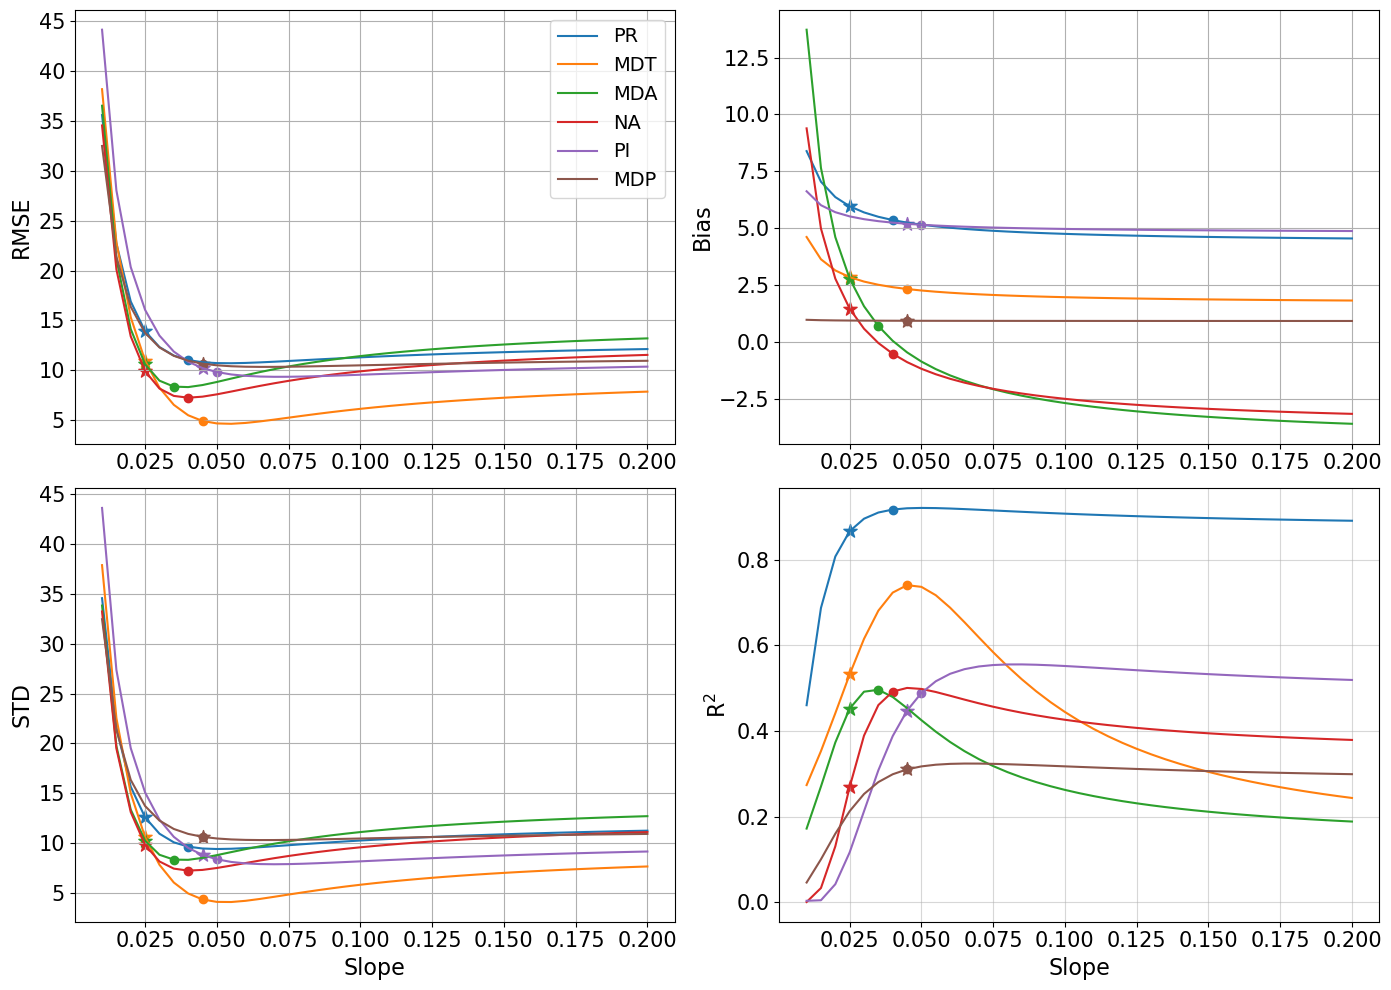

In [5]:
#Crate Figure to visualice results

slope_values_rounded = [round(p, 3) for p in slope_values]
def round_to_nearest_005(values):
    return np.round(values / 0.005) * 0.005
    
pend_slope = -slope_cs
pend_situ= -round_to_nearest_005(slope_insitu)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Subplot 1: RMSE
for i, key in enumerate(keys):
    axs[0, 0].plot(slope_values_rounded, stats_dict_nested[key]['rmse'], label=key)
    if round(pend_slope[i], 3) in slope_values_rounded:
        idx = slope_values_rounded.index(round(pend_slope[i], 3))
        axs[0, 0].scatter(slope_values_rounded[idx], stats_dict_nested[key]['rmse'][idx], color=axs[0, 0].lines[-1].get_color())
    if round(pend_situ[i], 3) in slope_values_rounded:
        idx = slope_values_rounded.index(round(pend_situ[i], 3))
        axs[0, 0].scatter(slope_values_rounded[idx], stats_dict_nested[key]['rmse'][idx], color=axs[0, 0].lines[-1].get_color(), marker='*',s=100)
#axs[0, 0].set_xlabel('Slope',fontsize=16)
axs[0, 0].set_ylabel('RMSE',fontsize=16)
axs[0, 0].legend(fontsize=14)
axs[0, 0].tick_params(axis='both', which='major', labelsize=15)
axs[0, 0].grid(True)

# Subplot 2: Bias
for i, key in enumerate(keys):
    axs[0, 1].plot(slope_values_rounded, stats_dict_nested[key]['bias'], label=key)
    if round(pend_slope[i], 3) in slope_values_rounded:
        idx = slope_values_rounded.index(round(pend_slope[i], 3))
        axs[0, 1].scatter(slope_values_rounded[idx], stats_dict_nested[key]['bias'][idx], color=axs[0, 1].lines[-1].get_color())
    if round(pend_situ[i], 3) in slope_values_rounded:
        idx = slope_values_rounded.index(round(pend_situ[i], 3))
        axs[0, 1].scatter(slope_values_rounded[idx], stats_dict_nested[key]['bias'][idx], color=axs[0, 1].lines[-1].get_color(), marker='*',s=100)
#axs[0, 1].set_xlabel('Slope',fontsize=16)
axs[0, 1].set_ylabel('Bias',fontsize=16)
axs[0, 1].tick_params(axis='both', which='major', labelsize=15)
axs[0, 1].grid(True)

# Subplot 3: STD
for i, key in enumerate(keys):
    axs[1, 0].plot(slope_values_rounded, stats_dict_nested[key]['std'], label=key)
    if round(pend_slope[i], 3) in slope_values_rounded:
        idx = slope_values_rounded.index(round(pend_slope[i], 3))
        axs[1, 0].scatter(slope_values_rounded[idx], stats_dict_nested[key]['std'][idx], color=axs[1, 0].lines[-1].get_color())
    if round(pend_situ[i], 3) in slope_values_rounded:
        idx = slope_values_rounded.index(round(pend_situ[i], 3))
        axs[1, 0].scatter(slope_values_rounded[idx], stats_dict_nested[key]['std'][idx], color=axs[1, 0].lines[-1].get_color(), marker='*',s=100)
axs[1, 0].set_xlabel('Slope',fontsize=16)
axs[1, 0].set_ylabel('STD',fontsize=16)
axs[1, 0].tick_params(axis='both', which='major', labelsize=15)
axs[1, 0].grid(True)

# Subplot 4: R2
for i, key in enumerate(keys):
    axs[1, 1].plot(slope_values_rounded, stats_dict_nested[key]['r2'], label=key)
    if round(pend_slope[i], 3) in slope_values_rounded:
        idx = slope_values_rounded.index(round(pend_slope[i], 3))
        axs[1, 1].scatter(slope_values_rounded[idx], stats_dict_nested[key]['r2'][idx], color=axs[1, 1].lines[-1].get_color())
    if round(pend_situ[i], 3) in slope_values_rounded:
        idx = slope_values_rounded.index(round(pend_situ[i], 3))
        axs[1, 1].scatter(slope_values_rounded[idx], stats_dict_nested[key]['r2'][idx], color=axs[1, 1].lines[-1].get_color(), marker='*',s=100)
axs[1, 1].set_xlabel('Slope',fontsize=16)
axs[1, 1].set_ylabel('R$^2$',fontsize=16)
axs[1, 1].tick_params(axis='both', which='major', labelsize=15)
axs[1, 1].grid(True,alpha=0.5)

plt.tight_layout()
plt.savefig(os.path.join(dir_output,'assesment with diferents slopes.png'),dpi=200)